## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.figure import Figure
from scipy.signal import correlate
from scipy.stats import zscore
import numpy as np
import datetime as dt

from stock_modules.stock_transform import add_time_delta_column

# Read the data from the csv file
df = pd.read_csv('HEL_12-10-21to08-11-23.csv')
# Set date as date and add time delta col
df["date"] = pd.to_datetime(df["date"])
df = add_time_delta_column(df, date_col_name="date")

print(df.head())
print(df.describe())

                 date  Time Delta   REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE  \
0 2021-10-12 07:00:00           1  55.950001  41.820000  35.689999  60.220001   
1 2021-10-12 08:00:00           1  55.799999  41.720001  35.630001  60.419998   
2 2021-10-12 09:00:00           1  55.700001  42.060001  35.400002  60.200001   
3 2021-10-12 10:00:00           1  55.450001  42.009998  35.500000  60.119999   
4 2021-10-12 11:00:00           2  56.000000  42.000000  35.680000  60.480000   

    OLVAS.HE   HUH1V.HE   DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
0  53.099998  38.529999  23.000000  38.049999  43.139999  46.150002   
1  53.299999  38.560001  23.000000  38.049999  43.500000  45.950001   
2  53.200001  38.349998  23.000000  38.049999  43.619999  45.849998   
3  52.900002  38.220001  23.200001  38.049999  43.480000  45.700001   
4  52.599998  38.349998  23.200001  38.000000  43.279999  45.650002   

    ALBBV.HE   VALMT.HE   EQV1V.HE   PON1V.HE  
0  28.700001  36.459999  24.850000  39

## Exploratory Data Analysis

                      REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
date                                                                         
2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   
2021-10-12 09:00:00  55.700001  42.060001  35.400002  60.200001  53.200001   
2021-10-12 10:00:00  55.450001  42.009998  35.500000  60.119999  52.900002   
2021-10-12 11:00:00  56.000000  42.000000  35.680000  60.480000  52.599998   

                      HUH1V.HE   DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
date                                                                         
2021-10-12 07:00:00  38.529999  23.000000  38.049999  43.139999  46.150002   
2021-10-12 08:00:00  38.560001  23.000000  38.049999  43.500000  45.950001   
2021-10-12 09:00:00  38.349998  23.000000  38.049999  43.619999  45.849998   
2021-10-12 10:00:00  38.220001  23.200001  38.049999  43.480000

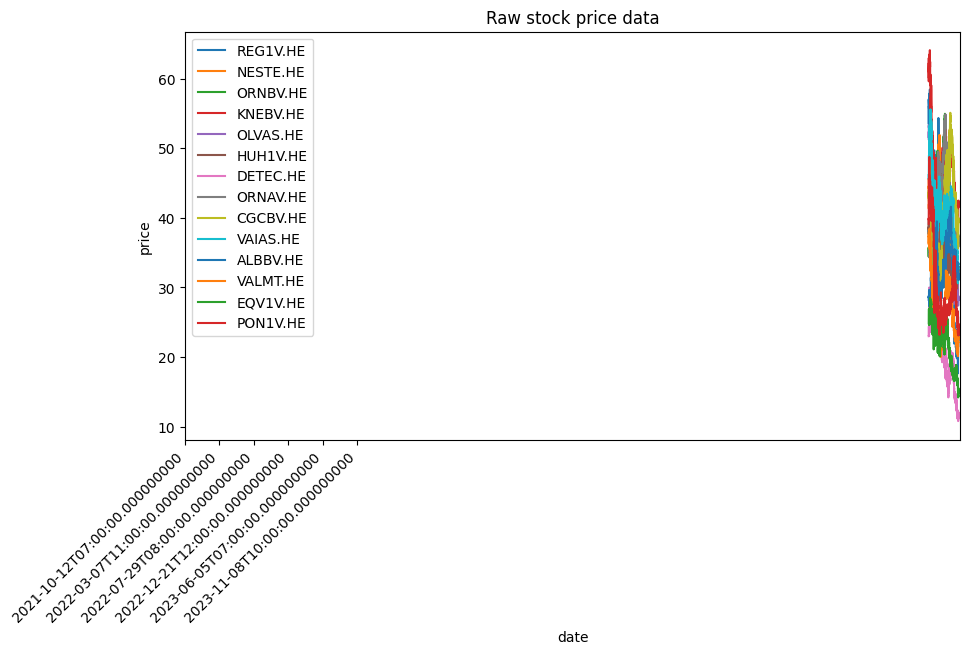

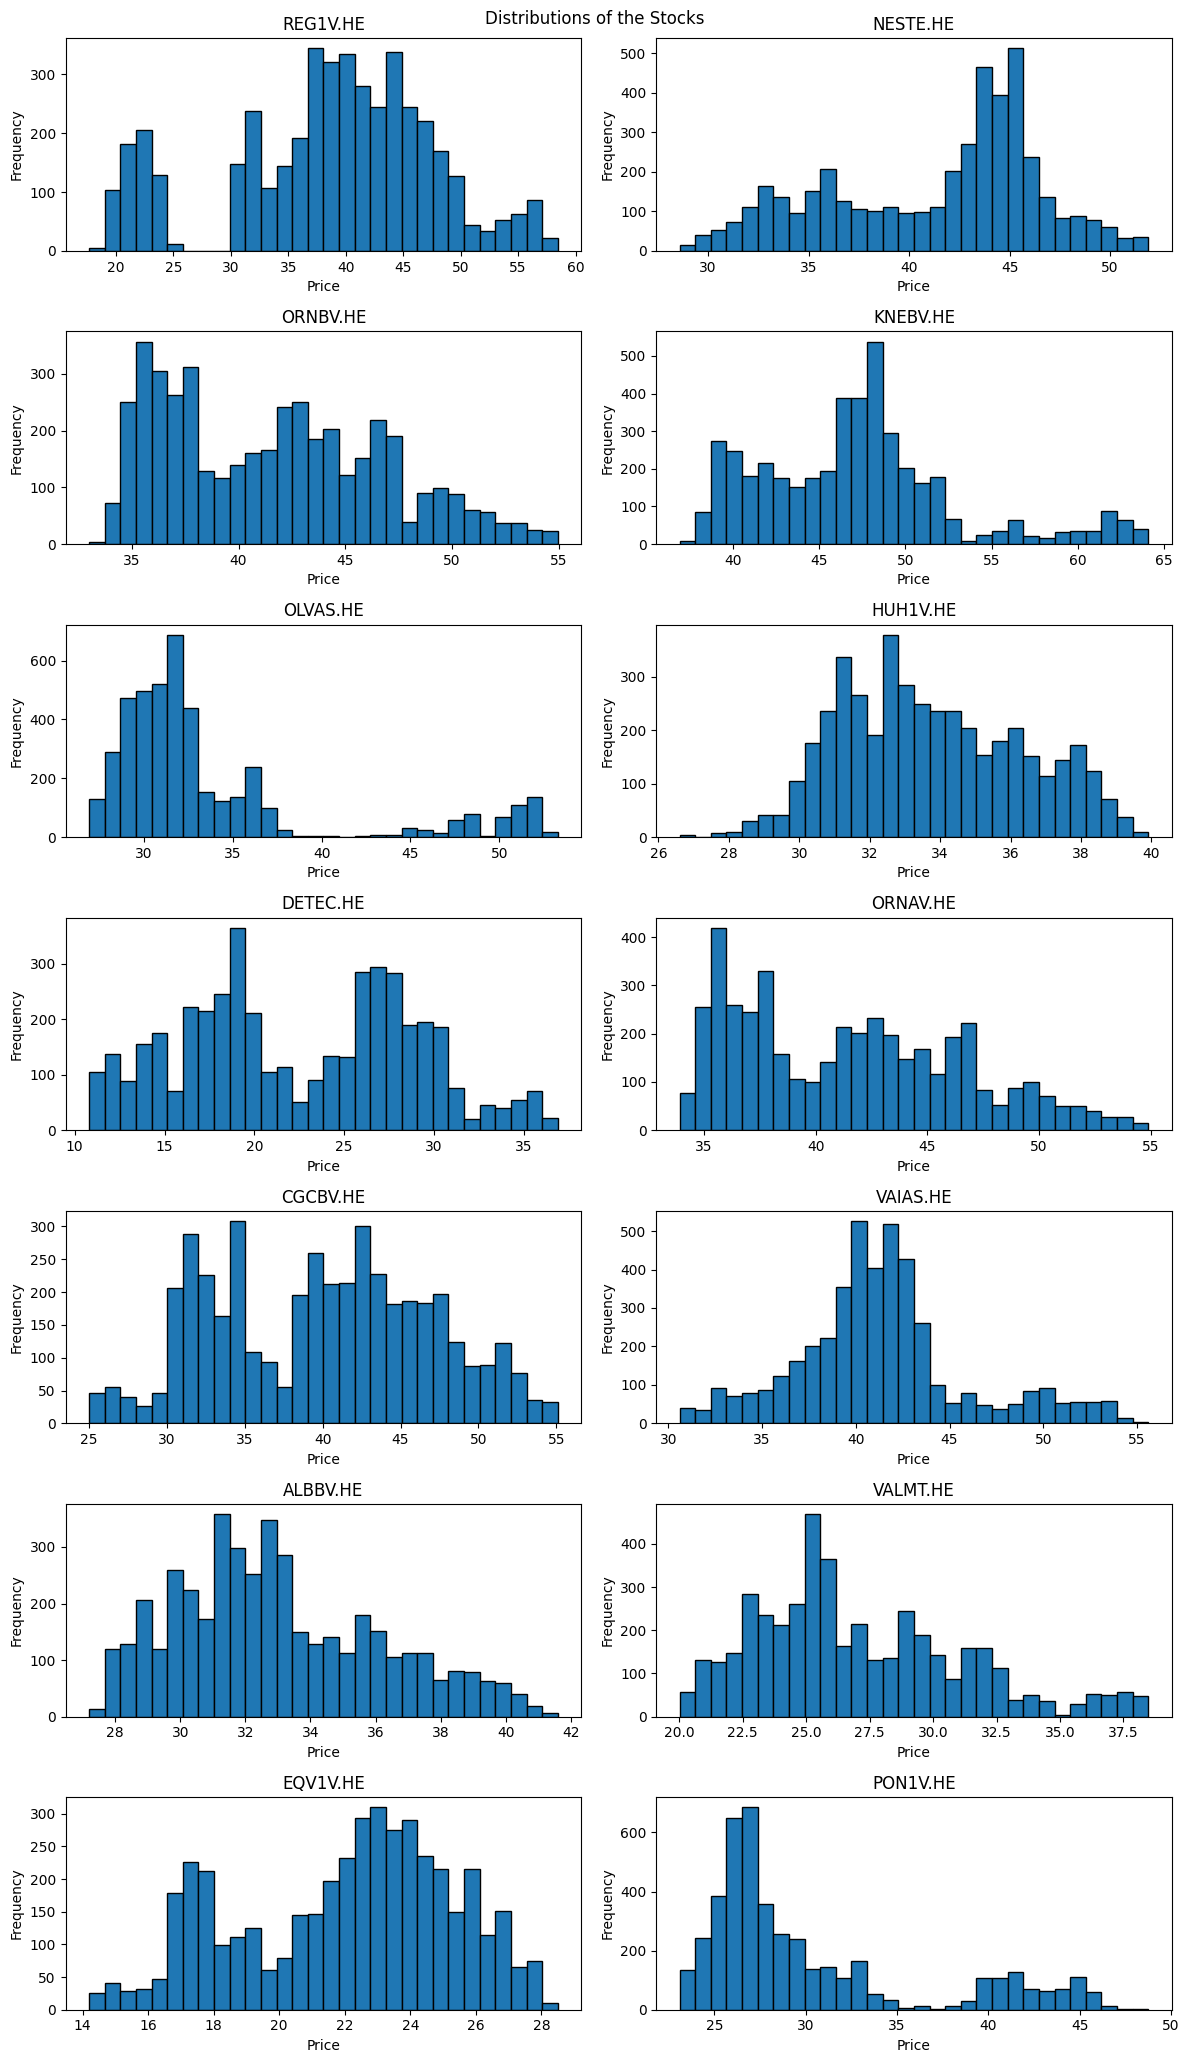

In [3]:
df_custom = df.drop(columns=["Time Delta"]).set_index("date")
print(df_custom.head())

fig, ax = plt.subplots(figsize=(10, 6))

df_custom.plot(ax=ax)

num_ticks = 5
xticks_idx = range(0, len(df_custom), len(df_custom)//num_ticks)
plt.xticks(xticks_idx, df_custom.index[xticks_idx].values, rotation=45)

plt.title('Raw stock price data')
plt.xlabel('date')
plt.ylabel('price')

fig.savefig("./figures/raw.svg")

num_columns = len(df_custom.columns)

# Calculate how many rows and columns for subplot
num_rows = (num_columns + 1) // 2  # Add 1 to round up for odd numbers
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

for i, column in enumerate(df_custom.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    
    ax.hist(df_custom[column], bins=30, edgecolor='black')
    ax.set_title(f'{column}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

plt.suptitle('Distributions of the Stocks', )

plt.tight_layout()
plt.show()

fig.savefig("./figures/distributions.svg")

## Instant Cross-Correlation

## Time Auto-Correlation

In [85]:
df_custom = df.copy()
df_custom.set_index("date", inplace=True)

def find_ij_pairs(df : pd.DataFrame, td : int, max_pairs=None):
    """ Find the i-j pairs for a given time difference.
    - Find all pairs of indices (i,j), such that the total time difference sum(td(i:j)) is equal to the time difference.
    """
    if max_pairs is None:
        max_pairs = float("inf")
    i_j_pairs = []
    td_values = df["Time Delta"].values
    cumsum = np.cumsum(td_values)
    # adj_cumsum contains a cumsum from i to end for the current i
    adj_cumsum = cumsum.copy()
    for i in range(len(df)):
        #print(f"Adjusted cumsum: {adj_cumsum}")
        # Calculate a cumsum from i to end by subtracting the i-1 time delta value from 
        adj_cumsum = cumsum[i:] - cumsum[i-1] if i > 0 else cumsum[i:]
        # Find the first index where the cumsum is equal or greater than td
        j = np.argmax(adj_cumsum >= td)
        #print(f"i: {i}, j: {j}, cumsum_i[j]: {cumsum_i[j]}")
        # If the cumsum is equal to td, add the pair to the list
        if adj_cumsum[j] == td:
            j += i
            i_j_pairs.append((i,j))
        if len(i_j_pairs) >= max_pairs:
            break
    return i_j_pairs

time_diffs = (1,52*24*7,24)
#time_diffs = (1,78,1)
i_j_pairs_map = {}
for td in range(time_diffs[0], time_diffs[1]+1, time_diffs[2]):
    i_j_pairs_map[td] = find_ij_pairs(df_custom, td, max_pairs=None)
    print(f"Time difference: {td} hours, number of pairs: {len(i_j_pairs_map[td])}")

Time difference: 1 hours, number of pairs: 3592
Time difference: 25 hours, number of pairs: 2806
Time difference: 49 hours, number of pairs: 2106
Time difference: 73 hours, number of pairs: 2012
Time difference: 97 hours, number of pairs: 1994
Time difference: 121 hours, number of pairs: 2100
Time difference: 145 hours, number of pairs: 2815
Time difference: 169 hours, number of pairs: 3454
Time difference: 193 hours, number of pairs: 2787
Time difference: 217 hours, number of pairs: 2072
Time difference: 241 hours, number of pairs: 1971
Time difference: 265 hours, number of pairs: 1988
Time difference: 289 hours, number of pairs: 2083
Time difference: 313 hours, number of pairs: 2788
Time difference: 337 hours, number of pairs: 3420
Time difference: 361 hours, number of pairs: 2771
Time difference: 385 hours, number of pairs: 2069
Time difference: 409 hours, number of pairs: 1972
Time difference: 433 hours, number of pairs: 1979
Time difference: 457 hours, number of pairs: 2059
Time d

In [86]:
%matplotlib widget
stock_names = df_custom.columns[1:]
stock_auto_corrs = {}
print(i_j_pairs_map.keys())
for stock in stock_names:
    stock_auto_corrs[stock] = []
    for td in range(time_diffs[0], time_diffs[1]+1, time_diffs[2]):
        # Calculate the pearson correlation between the stock price at i and j
        stock_prices = np.array(df_custom[stock])
        prices_at_i = stock_prices[[i for i,j in i_j_pairs_map[td]]]
        prices_at_j = stock_prices[[j for i,j in i_j_pairs_map[td]]]
        if len(prices_at_i) <= 2:
            stock_auto_corrs[stock].append(np.nan)
            continue
        correlation = np.corrcoef(prices_at_i, prices_at_j)[0,1]
        stock_auto_corrs[stock].append(correlation)
        print(f"Stock: {stock}, Time Diff: {td}, Correlation: {correlation}")
                    


dict_keys([1, 25, 49, 73, 97, 121, 145, 169, 193, 217, 241, 265, 289, 313, 337, 361, 385, 409, 433, 457, 481, 505, 529, 553, 577, 601, 625, 649, 673, 697, 721, 745, 769, 793, 817, 841, 865, 889, 913, 937, 961, 985, 1009, 1033, 1057, 1081, 1105, 1129, 1153, 1177, 1201, 1225, 1249, 1273, 1297, 1321, 1345, 1369, 1393, 1417, 1441, 1465, 1489, 1513, 1537, 1561, 1585, 1609, 1633, 1657, 1681, 1705, 1729, 1753, 1777, 1801, 1825, 1849, 1873, 1897, 1921, 1945, 1969, 1993, 2017, 2041, 2065, 2089, 2113, 2137, 2161, 2185, 2209, 2233, 2257, 2281, 2305, 2329, 2353, 2377, 2401, 2425, 2449, 2473, 2497, 2521, 2545, 2569, 2593, 2617, 2641, 2665, 2689, 2713, 2737, 2761, 2785, 2809, 2833, 2857, 2881, 2905, 2929, 2953, 2977, 3001, 3025, 3049, 3073, 3097, 3121, 3145, 3169, 3193, 3217, 3241, 3265, 3289, 3313, 3337, 3361, 3385, 3409, 3433, 3457, 3481, 3505, 3529, 3553, 3577, 3601, 3625, 3649, 3673, 3697, 3721, 3745, 3769, 3793, 3817, 3841, 3865, 3889, 3913, 3937, 3961, 3985, 4009, 4033, 4057, 4081, 4105, 4129,

## Trend-Seasonality Decomposition

[0.0013888888888888887, 0.034722222222222224, 0.06805555555555555, 0.10138888888888889, 0.13472222222222224, 0.16805555555555557, 0.2013888888888889, 0.23472222222222222, 0.26805555555555555, 0.3013888888888889, 0.3347222222222222, 0.3680555555555555, 0.40138888888888885, 0.4347222222222222, 0.46805555555555556, 0.5013888888888889, 0.5347222222222222, 0.5680555555555556, 0.601388888888889, 0.6347222222222223, 0.6680555555555556, 0.701388888888889, 0.7347222222222223, 0.7680555555555556, 0.8013888888888889, 0.8347222222222223, 0.8680555555555556, 0.9013888888888889, 0.9347222222222222, 0.9680555555555556, 1.0013888888888889, 1.0347222222222223, 1.0680555555555555, 1.1013888888888888, 1.1347222222222222, 1.1680555555555554, 1.2013888888888888, 1.234722222222222, 1.2680555555555555, 1.3013888888888887, 1.3347222222222221, 1.3680555555555556, 1.4013888888888888, 1.4347222222222222, 1.4680555555555554, 1.5013888888888889, 1.534722222222222, 1.5680555555555555, 1.6013888888888888, 1.63472222

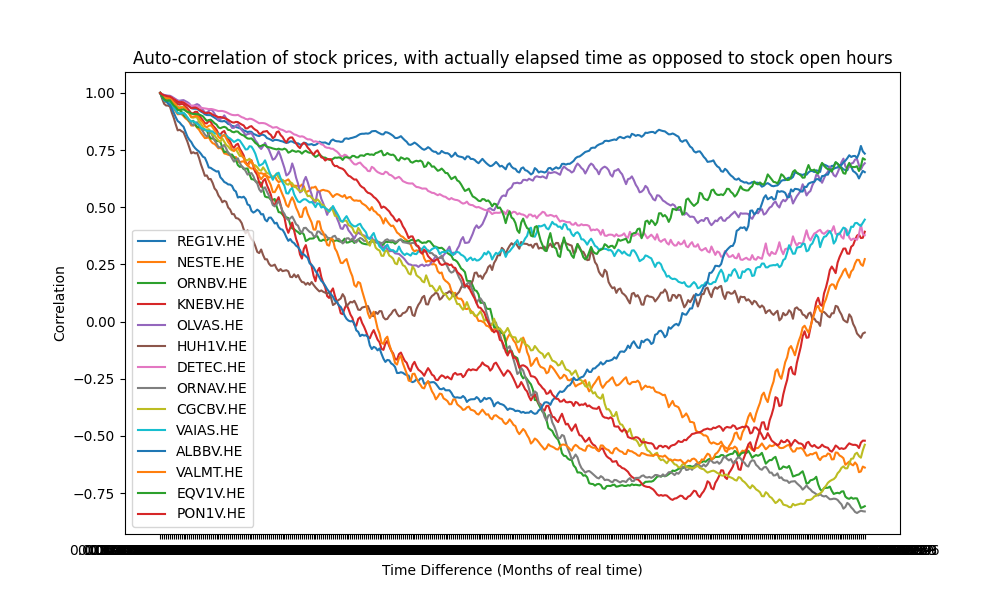

In [91]:
# Plot the auto-correlations
fig, ax = plt.subplots(figsize=(10, 6))
tds = list(range(time_diffs[0], time_diffs[1]+1,time_diffs[2]))
for stock in stock_names:
    # Stock vals has nan values for time diffs where there are not enough data points
    stock_vals = stock_auto_corrs[stock]
    ax.plot(tds, stock_vals, label=stock)
ax.set_xlabel("Time Difference (Months of real time)")
ax.set_ylabel("Correlation")
ax.set_title("Auto-correlation of stock prices, with actually elapsed time as opposed to stock open hours")

plt.legend()
plt.show()

df_custom shape: (4389, 14)
df_custom shape: (18175, 14)
Period: 8, Entropy of residuals: 8.488120925980963
Best period: 8, Entropy of residuals: 8.488120925980963


C:\Users\ilmari\AppData\Local\Temp\ipykernel_19672\3586415451.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_custom = df_custom.append(pd.DataFrame(index=missing_indices, columns=df_custom.columns))


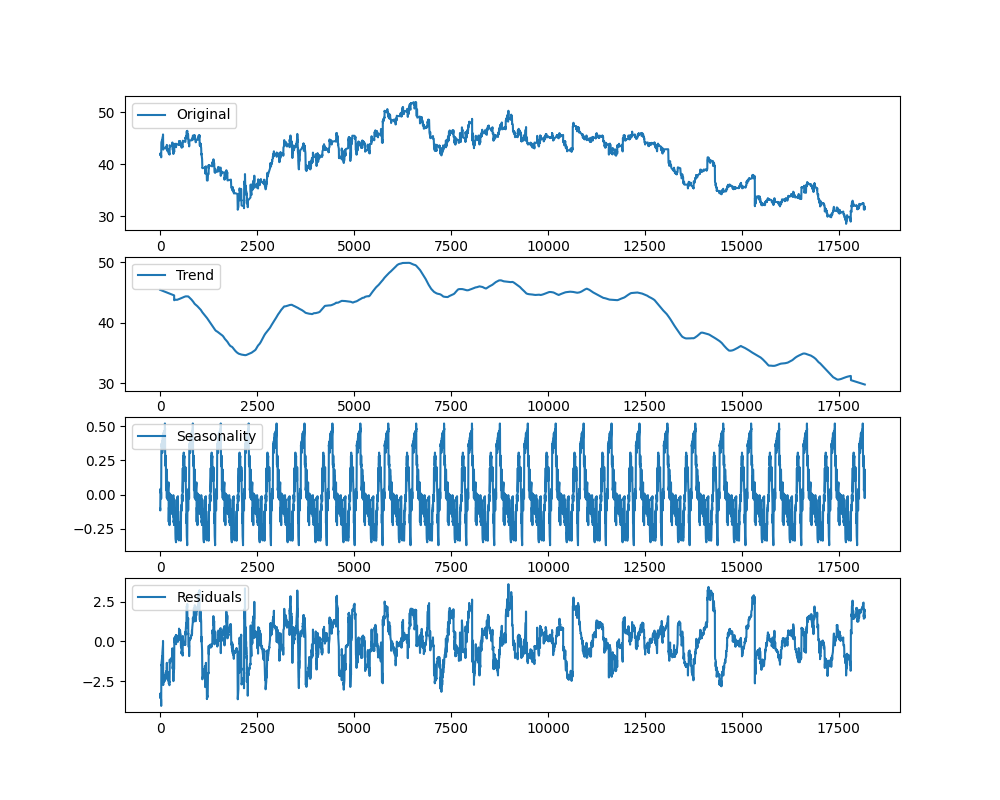

In [20]:
# Decompose PON1V.HE into trend, seasonal and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
# Measure entropy of a series
from scipy.special import entr
def entropy(series):
    """ Calculate the entropy of a series. """
    series = series.values
    series = zscore(series)
    series = np.nan_to_num(series, nan=0)
    series = np.abs(series)
    series = series / series.sum()
    return entr(series).sum()

df_custom = df.copy()
df_custom["Total hours"] = np.cumsum(df_custom["Time Delta"])
df_custom.set_index("Total hours", inplace=True)
df_custom.drop(["date", "Time Delta"], axis=1, inplace=True)
print(f"df_custom shape: {df_custom.shape}")
# The spacing in the indices should be one, but it is not.
# We fix this by adding the missing indices, filling them with NaNs, and then interpolating.
curr_indices = df_custom.index.to_list()
full_indices = list(range(int(curr_indices[0]), int(curr_indices[-1])))
missing_indices = list(set(full_indices) - set(curr_indices))
# Add rows with nan values at each index of missing values
df_custom = df_custom.append(pd.DataFrame(index=missing_indices, columns=df_custom.columns))
# Sort the dataframe by index
df_custom.sort_index(inplace=True)
# Interpolate the missing values
df_custom.interpolate(method='linear', inplace=True)
print(f"df_custom shape: {df_custom.shape}")




stock_name = "NESTE.HE"
stock = df_custom[stock_name]

# Check different periods, and measure the entropy of the residuals
best_period = 8
most_entropy = 0
for period in range(8, 9, 1):
    result = seasonal_decompose(stock, model='additive', period=period, extrapolate_trend=1)
    entropy_resid = entropy(result.resid)
    print(f"Period: {period}, Entropy of residuals: {entropy_resid}")
    if entropy_resid > most_entropy:
        most_entropy = entropy_resid
        best_period = period
print(f"Best period: {best_period}, Entropy of residuals: {most_entropy}")

result = seasonal_decompose(stock, model='additive', period=30*24, extrapolate_trend="freq")

# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(stock, label='Original')
axes[0].legend(loc='upper left')
axes[1].plot(result.trend, label='Trend')
axes[1].legend(loc='upper left')
axes[2].plot(result.seasonal, label='Seasonality')
axes[2].legend(loc='upper left')
axes[3].plot(result.resid, label='Residuals')
axes[3].legend(loc='upper left')
plt.show()





